In [32]:
import os
import pathlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import random
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation, GlobalMaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import splitfolders

In [33]:
# splits dataset it into three subfolders: train, val (validation), and test.

splitfolders.ratio(r"C:\Users\Ajay\Desktop\Inno_Projects\Tamil_Sign_Language\Dataset", output="output",
    seed=1337, ratio=(.75, .2, .05), group_prefix=None, move=False)

Copying files: 1557 files [00:02, 641.40 files/s]


In [34]:
data_dir = pathlib.Path('output/')
train_dir = 'output/train'
val_dir = 'output/val'
test_dir = 'output/test'

In [35]:
class_name = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_name)

['test' 'train' 'val']


In [36]:
for dirpath, dirnames, filenames in os.walk('output'):
  print(f"{len(dirnames)} folder and {len(filenames)} images in {dirpath}")

3 folder and 0 images in output
13 folder and 0 images in output\test
0 folder and 6 images in output\test\1
0 folder and 7 images in output\test\10
0 folder and 6 images in output\test\11
0 folder and 7 images in output\test\12
0 folder and 7 images in output\test\13
0 folder and 7 images in output\test\2
0 folder and 7 images in output\test\3
0 folder and 7 images in output\test\4
0 folder and 7 images in output\test\5
0 folder and 7 images in output\test\6
0 folder and 8 images in output\test\7
0 folder and 7 images in output\test\8
0 folder and 8 images in output\test\9
13 folder and 0 images in output\train
0 folder and 76 images in output\train\1
0 folder and 94 images in output\train\10
0 folder and 90 images in output\train\11
0 folder and 94 images in output\train\12
0 folder and 85 images in output\train\13
0 folder and 87 images in output\train\2
0 folder and 85 images in output\train\3
0 folder and 85 images in output\train\4
0 folder and 87 images in output\train\5
0 folde

In [37]:
def view_random_image(target_dir, target_class):
    target_folder = target_dir + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")
    
    print(f"Image Shape : {img.shape}")
    plt.show()

Image Shape : (480, 640, 3)


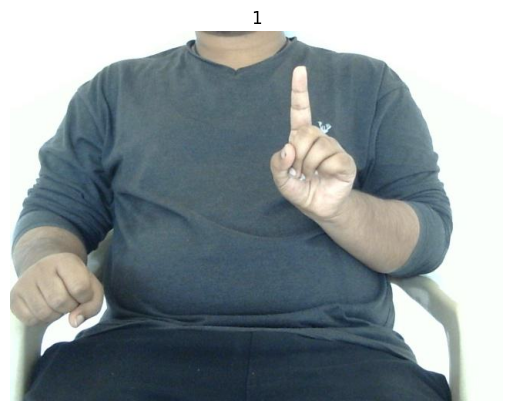

In [38]:
for i in range(1,2):
    img_n = view_random_image(target_dir='output/train/', target_class='1')

In [39]:
# Sets the global random seed.
tf.random.set_seed(46)

# preprocess data
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                   rotation_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   vertical_flip=True,
                                   horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)

In [40]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=46)

valid_data = valid_datagen.flow_from_directory(val_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=46)

test_data = test_datagen.flow_from_directory(test_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=46)

Found 1161 images belonging to 13 classes.
Found 305 images belonging to 13 classes.
Found 91 images belonging to 13 classes.


In [41]:
train_data.class_indices

{'1': 0,
 '10': 1,
 '11': 2,
 '12': 3,
 '13': 4,
 '2': 5,
 '3': 6,
 '4': 7,
 '5': 8,
 '6': 9,
 '7': 10,
 '8': 11,
 '9': 12}

In [42]:
train_y=train_data.classes
val_y=valid_data.classes
test_y=test_data.classes

In [43]:
print("train_y.shape: ", train_y.shape)
print("val_y.shape: ", val_y.shape)
print("test_y.shape: ", test_y.shape)

train_y.shape:  (1161,)
val_y.shape:  (305,)
test_y.shape:  (91,)


In [44]:
import os
import shutil
import yaml
import torch
from ultralytics import YOLO

# Paths to the dataset
train_path = os.path.abspath('output/train')
val_path = os.path.abspath('output/val')
test_path = os.path.abspath('output/test')

# Verify if these directories exist
if not os.path.exists(train_path):
    print(f"Error: {train_path} does not exist")
if not os.path.exists(val_path):
    print(f"Error: {val_path} does not exist")
if not os.path.exists(test_path):
    print(f"Error: {test_path} does not exist")

# YOLO requires a custom yaml config file
yaml_content = f"""
train: {train_path}  # path to train dataset
val: {val_path}      # path to validation dataset
nc: 13               # number of classes (as per your dataset)
names: {['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']}  # class names
"""

# Save the YAML file for YOLOv5 dataset configuration
yaml_file = 'custom_dataset.yaml'
with open(yaml_file, 'w') as f:
    f.write(yaml_content)

# Check if CUDA is available and set the device accordingly
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Download YOLOv5s model with ResNet50 backbone (YOLOv5s is lightweight)
model = YOLO("yolov5s.yaml")  # You can modify this to specify any custom backbone

# Train the model with custom dataset
results = model.train(data=yaml_file, epochs=1, batch=16, imgsz=224, device=device)  # You can adjust the parameters

# Retrieve model weights and evaluation metrics
weights = model.best # Get the best weights from training
accuracy = results.metrics  # Accuracy and other metrics during training

# Save the weights to a specific directory
shutil.copy(weights, './best_model_weights.pt')

# Display results
print(f"Training results: {results}")
print(f"Best weights saved to: ./best_model_weights.pt")


Ultralytics 8.3.53  Python-3.10.16 torch-2.5.1+cpu CPU (Intel Core(TM) i5-10300H 2.50GHz)
engine\trainer: task=detect, mode=train, model=yolov5s.yaml, data=custom_dataset.yaml, epochs=1, time=None, patience=100, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_box

train: Scanning C:\Users\Ajay\Desktop\Inno_Projects\Tamil_Sign_Language\output\train\10... 0 images, 1161 backgrounds, 0 corrupt: 100%|██████████| 1161/1161 [00:01<00:00, 584.03it/s]

train: WARNING  No labels found in C:\Users\Ajay\Desktop\Inno_Projects\Tamil_Sign_Language\output\train\10.cache. See https://docs.ultralytics.com/datasets for dataset formatting guidance.


train: New cache created: C:\Users\Ajay\Desktop\Inno_Projects\Tamil_Sign_Language\output\train\10.cache
WARNING  No labels found in C:\Users\Ajay\Desktop\Inno_Projects\Tamil_Sign_Language\output\train\10.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.


val: Scanning C:\Users\Ajay\Desktop\Inno_Projects\Tamil_Sign_Language\output\val\10... 0 images, 305 backgrounds, 0 corrupt: 100%|██████████| 305/305 [00:00<00:00, 614.45it/s]

val: WARNING  No labels found in C:\Users\Ajay\Desktop\Inno_Projects\Tamil_Sign_Language\output\val\10.cache. See https://docs.ultralytics.com/datasets for dataset formatting guidance.
val: New cache created: C:\Users\Ajay\Desktop\Inno_Projects\Tamil_Sign_Language\output\val\10.cache
WARNING  No labels found in C:\Users\Ajay\Desktop\Inno_Projects\Tamil_Sign_Language\output\val\10.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.
Plotting labels to runs\detect\train5\labels.jpg... 


zero-size array to reduction operation maximum which has no identity
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000588, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 224 train, 224 val
Using 0 dataloader workers
Logging results to runs\detect\train5
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1         0G          0      14.27          0          0        224: 100%|██████████| 73/73 [02:26<00:00,  2.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:13<00:00,  1.31s/it]

                   all        305          0          0          0          0          0
WARNING  no labels found in detect set, can not compute metrics without labels



1 epochs completed in 0.047 hours.
Optimizer stripped from runs\detect\train5\weights\last.pt, 18.5MB
Optimizer stripped from runs\detect\train5\weights\best.pt, 18.5MB

Validating runs\detect\train5\weights\best.pt...
Ultralytics 8.3.53  Python-3.10.16 torch-2.5.1+cpu CPU (Intel Core(TM) i5-10300H 2.50GHz)
YOLOv5s summary (fused): 193 layers, 9,116,567 parameters, 0 gradients, 23.9 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:11<00:00,  1.12s/it]

                   all        305          0          0          0          0          0
WARNING  no labels found in detect set, can not compute metrics without labels


Speed: 0.4ms preprocess, 29.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs\detect\train5


AttributeError: 'DetectionModel' object has no attribute 'best'

In [60]:
import os
from ultralytics import YOLO

# Set paths for your dataset directories
train_dir = r"C:\Users\Ajay\Desktop\Inno_Projects\Tamil_Sign_Language\output\train"
val_dir = r"C:\Users\Ajay\Desktop\Inno_Projects\Tamil_Sign_Language\output\val"

# Check if the train and val directories exist and are not empty
if not os.path.exists(train_dir) or not os.listdir(train_dir):
    print(f"Error: {train_dir} does not contain any images.")
else:
    print(f"Train directory found: {train_dir}")

if not os.path.exists(val_dir) or not os.listdir(val_dir):
    print(f"Error: {val_dir} does not contain any images.")
else:
    print(f"Validation directory found: {val_dir}")

# Path to the dataset YAML file
yaml_file = "custom_dataset.yaml"

# Check if YAML file exists
if not os.path.exists(yaml_file):
    print(f"Error: YAML file {yaml_file} does not exist.")
else:
    print(f"YAML file found: {yaml_file}")

# Define the device (ensure CUDA is not required if not available)
device = "cpu"  # Change to '0' or the appropriate GPU device ID if CUDA is available

# Define the model
model = YOLO("yolov5s.yaml")  # Using YOLOv5 small model, you can change this to another model

# Check if the directories are populated before starting training
if os.path.exists(train_dir) and os.listdir(train_dir) and os.path.exists(val_dir) and os.listdir(val_dir):
    # Train the model with TensorBoard enabled
    try:
        print(f"Training model using dataset {yaml_file}...")
        results = model.train(
            data=yaml_file,  # Path to your custom dataset YAML file
            epochs=1,         # Number of epochs to train
            batch=16,         # Batch size
            imgsz=224,        # Image size
            device=device,    # Training device (CPU or GPU)
            exist_ok=True,    # Overwrite previous runs if exists
            name='tboard'     # TensorBoard log name
        )

        # After each epoch, retrieve and print metrics like mAP
        for epoch in range(results.epochs):  # Loop through each epoch
            metrics = results.metrics  # Access training metrics
            if 'mAP50' in metrics:
                print(f"Epoch {epoch + 1} - mAP50: {metrics['mAP50']:.4f}")  # Print mAP at 50 IoU
            else:
                print(f"Epoch {epoch + 1} - No mAP50 found.")

    except Exception as e:
        print(f"Error during training: {str(e)}")
else:
    print("Please ensure your dataset is correctly placed and populated.")

# After training, check accuracy and save the best model
try:
    # Retrieve model weights
    best_model = model.best  # Get the best model weights from training
    print(f"Best weights saved at: {best_model}")
    
    # Retrieve evaluation metrics for the best model
    metrics = results.metrics  # Access training metrics after training
    accuracy = metrics['mAP50']  # This is mAP@50, you can adjust for mAP@50-95 as well
    print(f"Accuracy (mAP50): {accuracy}")

    # Optionally, save the best model
    model.save("best_model.pt")
    print("Best model saved as 'best_model.pt'.")

except Exception as e:
    print(f"Error retrieving model weights or metrics: {str(e)}")


Train directory found: C:\Users\Ajay\Desktop\Inno_Projects\Tamil_Sign_Language\output\train
Validation directory found: C:\Users\Ajay\Desktop\Inno_Projects\Tamil_Sign_Language\output\val
YAML file found: custom_dataset.yaml
Training model using dataset custom_dataset.yaml...
Ultralytics 8.3.53  Python-3.10.16 torch-2.5.1+cpu CPU (Intel Core(TM) i5-10300H 2.50GHz)
engine\trainer: task=detect, mode=train, model=yolov5s.yaml, data=custom_dataset.yaml, epochs=1, time=None, patience=100, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=tboard, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=

train: Scanning C:\Users\Ajay\Desktop\Inno_Projects\Tamil_Sign_Language\output\train\10.cache... 0 images, 1161 backgrounds, 0 corrupt: 100%|██████████| 1161/1161 [00:00<?, ?it/s]

WARNING  No labels found in C:\Users\Ajay\Desktop\Inno_Projects\Tamil_Sign_Language\output\train\10.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.



val: Scanning C:\Users\Ajay\Desktop\Inno_Projects\Tamil_Sign_Language\output\val\10.cache... 0 images, 305 backgrounds, 0 corrupt: 100%|██████████| 305/305 [00:00<?, ?it/s]

WARNING  No labels found in C:\Users\Ajay\Desktop\Inno_Projects\Tamil_Sign_Language\output\val\10.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.
Plotting labels to runs\detect\tboard\labels.jpg... 
zero-size array to reduction operation maximum which has no identity
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000588, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)


TensorBoard: model graph visualization added 
Image sizes 224 train, 224 val
Using 0 dataloader workers
Logging results to runs\detect\tboard
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1         0G          0      14.27          0          0        224: 100%|██████████| 73/73 [02:29<00:00,  2.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:12<00:00,  1.29s/it]

                   all        305          0          0          0          0          0
WARNING  no labels found in detect set, can not compute metrics without labels



1 epochs completed in 0.048 hours.
Optimizer stripped from runs\detect\tboard\weights\last.pt, 18.5MB
Optimizer stripped from runs\detect\tboard\weights\best.pt, 18.5MB

Validating runs\detect\tboard\weights\best.pt...
Ultralytics 8.3.53  Python-3.10.16 torch-2.5.1+cpu CPU (Intel Core(TM) i5-10300H 2.50GHz)
YOLOv5s summary (fused): 193 layers, 9,116,567 parameters, 0 gradients, 23.9 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]

                   all        305          0          0          0          0          0
WARNING  no labels found in detect set, can not compute metrics without labels


Speed: 0.5ms preprocess, 30.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs\detect\tboard
Error during training: 'DetMetrics' object has no attribute 'epochs'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP) of an
    object detection model.

    Args:
        save_dir (Path): A path to the directory where the output plots will be saved. Defaults to current directory.
        plot (bool): A flag that indicates whether to plot precision-recall curves for each class. Defaults to False.
        on_plot (func): An optional callback to pass plots path and data when they are rendered. Defaults to None.
        names (dict of str): A dict of strings that represents the names of the classes. Defaults to an empty tuple.

    Attributes:
        save_dir (Path): A path to the directory where the output plots will be saved.
        plot (bool): A flag that indicates whether to p

In [68]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import numpy as np

# Load InceptionV3 as a feature extractor, excluding the top (classification) layers
base_model = InceptionV3(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the base layers of the InceptionV3 model to prevent them from being trained initially
base_model.trainable = False

# Create a custom model using the InceptionV3 backbone and additional YOLOv5-style layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Pool the output features
    layers.Dense(512, activation='relu'),  # Fully connected layer
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(13, activation='softmax')  # Output layer for 13 classes (Tamil Sign Language classes)
])

# Compile the model with Adam optimizer
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary to check the architecture
model.summary()

# Train the model
history = model.fit(
    train_data,
    epochs=1,  # Number of epochs (you can adjust this based on your requirements)
    validation_data=valid_data
)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_data)
print(f" Accuracy: {test_acc * 100:.2f}%")



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 13)             │         6,669 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,858,541 (87.20 MB)

 Trainable params: 1,055,757 (4.03 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

19/19 ━━━━━━━━━━━━━━━━━━━━ 75s 4s/step - accuracy: 0.0818 - loss: 3.7181 - val_accuracy: 0.0525 - val_loss: 2.5944
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.0418 - loss: 2.6136
 Accuracy: 5.49%


In [66]:
# Save the entire model (architecture + weights)
model.save('inceptionv3_yolov5_model.h5')


In [70]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Load ResNet50 backbone without the top layers (to use as a feature extractor)
base_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the base model layers initially
base_model.trainable = False

# Create the custom object detection model using the ResNet50 backbone
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(13, activation='softmax')  # Output layer for 13 classes
])

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary to check the architecture
model.summary()

# Step 2: Set up the Data Generators

train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=20, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True)

valid_datagen = ImageDataGenerator(rescale=1./255)

# Load your dataset
train_data = train_datagen.flow_from_directory('output/train', 
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical', 
                                               shuffle=True, 
                                               seed=42)

valid_data = valid_datagen.flow_from_directory('output/val',
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical', 
                                               shuffle=False,
                                               seed=42)

# Step 3: Train the Model

history = model.fit(
    train_data,
    epochs=1,
    validation_data=valid_data
)

# Step 4: Evaluate the Model

test_data = valid_datagen.flow_from_directory('output/test', 
                                              batch_size=64, 
                                              target_size=(224, 224), 
                                              class_mode='categorical', 
                                              shuffle=False)

test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc * 100:.2f}%")




Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 13)             │         6,669 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,643,469 (94.01 MB)

 Trainable params: 1,055,757 (4.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Found 1161 images belonging to 13 classes.
Found 305 images belonging to 13 classes.
19/19 ━━━━━━━━━━━━━━━━━━━━ 111s 5s/step - accuracy: 0.0743 - loss: 2.9149 - val_accuracy: 0.0820 - val_loss: 2.6058
Found 91 images belonging to 13 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.0513 - loss: 2.6254   
Test Accuracy: 7.69%


ValueError: The filename must end in `.weights.h5`. Received: filepath=resnet50_yolov5_weights.h5

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Step 1: Load VGG16 Backbone (without top layers)
base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the VGG16 layers initially
base_model.trainable = False

# Step 2: Create Custom Model Using VGG16 Backbone
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Global pooling layer
    layers.Dense(512, activation='relu'),  # Fully connected layer
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(13, activation='softmax')  # Output layer for 13 classes (Tamil Sign Language classes)
])

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Check model summary
model.summary()

# Step 3: Prepare the Data Generators

train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=20, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True)

valid_datagen = ImageDataGenerator(rescale=1./255)

# Load the dataset
train_data = train_datagen.flow_from_directory('output/train', 
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical', 
                                               shuffle=True, 
                                               seed=42)

valid_data = valid_datagen.flow_from_directory('output/val',
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical', 
                                               shuffle=False,
                                               seed=42)

# Step 4: Train the Model
history = model.fit(
    train_data,
    epochs=1,
    validation_data=valid_data
)

# Step 5: Evaluate the Model

test_data = valid_datagen.flow_from_directory('output/test', 
                                              batch_size=64, 
                                              target_size=(224, 224), 
                                              class_mode='categorical', 
                                              shuffle=False)

test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Step 6: Save the Weights
model.save_weights('vgg16_yolov5_weights.h5')
